In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from scipy.io import loadmat
from pprint import pprint
from tqdm import trange, tqdm
from scipy.stats import ttest_ind, mannwhitneyu
from collections import defaultdict as ddict
from easydict import EasyDict as edict
from collections import Counter

%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, DATA_ROOT, RES_ROOT, FIG_ROOT

plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, load_pkl_folder2dict, save_pkl_dict2folder

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

In [4]:
# gtvdn
import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_singular_vals, update_kp

## Parameters

In [5]:
pprint(paras)

{'Cs': array([1.0e+02, 2.5e+01, 1.0e+01, 5.0e+00, 2.0e+00, 1.0e+00, 5.0e-01,
       2.0e-01, 1.0e-01, 5.0e-02, 1.0e-02]),
 'L': 100.0,
 'Lmin': 200,
 'T': 2,
 'cur_dir': PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg'),
 'cutoff': 0.6,
 'data_dir': PosixPath('../data'),
 'decimate_rate': 5,
 'downsample_rate': 20,
 'fct': 0.5,
 'fig_dir': PosixPath('../figs'),
 'is_detrend': True,
 'kappa': 3.21,
 'kps': array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805, 1.05105105, 1.05405405, 1.05705706,
       1.06006006, 1.06306306, 1.06606607, 1.06906907, 1.07207207,
       1.07507508, 1.07807808, 1.08108108, 1.08408408, 1.08708709,
       1.09009009, 1.09309309, 1.0960961 , 1.0990991 , 1.1021021 ,
       1.10510511, 1.10810811, 1.11111111, 1.11411411, 1.11711712,
       1.12012012

In [6]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method8"

In [7]:
# Lets save some results
post_paras = edict()

## Load results

In [18]:
# load results
cur_res = load_pkl_folder2dict(RES_ROOT/_paras.folder_name, including=["CPD*", "cpts_*", "ndX*", "nX*"])

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs_selected.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls_selected.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/nXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/nXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/ndXmats_AD.pkl
Load file /data/rajlab1/user_data/j

In [19]:
CPDresult = cur_res.CPDresult
cpts_ctrls = cur_res.cpts_ctrls
cpts_ADs = cur_res.cpts_ADs
ndXmats_AD = cur_res.ndXmats_AD
ndXmats_ctrl = cur_res.ndXmats_ctrl
nXmats_AD = cur_res.nXmats_AD
nXmats_ctrl = cur_res.nXmats_ctrl



B1 = CPDresult[0]
B2 = CPDresult[1]

##  Curves of singular values

In [20]:
CPDresult[-1].shape

(176, 20)

In [21]:
B3_abs_AD = np.abs(CPDresult[-1][88:, :])
B3_abs_ctrl = np.abs(CPDresult[-1][:88, :])

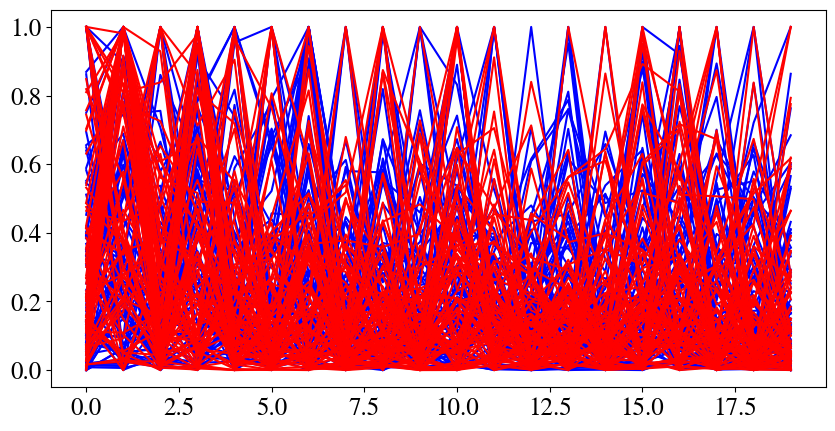

In [22]:
B3_abs_mm_AD = minmax_mat(B3_abs_AD, is_row=True)
B3_abs_mm_ctrl = minmax_mat(B3_abs_ctrl, is_row=True)
for ix in range(88):
    plt.plot(B3_abs_mm_AD[ix, :], "-b")
for ix in range(88):
    plt.plot(B3_abs_mm_ctrl[ix, :], "-r")

In [23]:
AD_mean = np.mean(B3_abs_mm_AD[:, :], axis=0)
AD_std = B3_abs_mm_AD.std(axis=0)
AD_low, AD_up = AD_mean - 1.96*AD_std/np.sqrt(88), AD_mean + 1.96*AD_std/np.sqrt(88)

ctrl_mean = np.mean(B3_abs_mm_ctrl[:, :], axis=0)
ctrl_std = B3_abs_mm_ctrl.std(axis=0)
ctrl_low, ctrl_up = ctrl_mean - 1.96*ctrl_std/np.sqrt(88), ctrl_mean + 1.96*ctrl_std/np.sqrt(88)

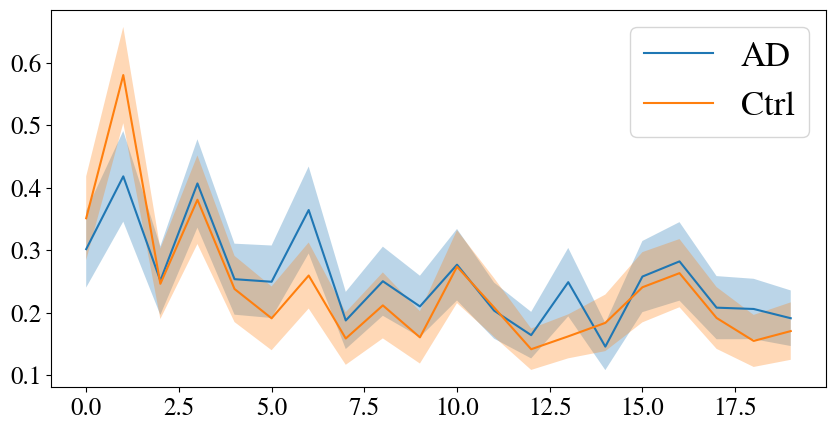

In [24]:
plt.plot(AD_mean, label="AD")
plt.plot(ctrl_mean, label="Ctrl")
plt.fill_between(np.arange(len(AD_low)), AD_low, AD_up, alpha=0.3)
plt.fill_between(np.arange(len(ctrl_low)), ctrl_low, ctrl_up, alpha=0.3)
plt.legend()

## Select kappa

In [25]:
# sel kappa
cpts_ctrls_allkp = []
_, cur_r, n = ndXmats_ctrl.shape
for kp in paras.kps:
    cpts_ctrl_allkp = np.array([update_kp(kp, ix.U0, n, cur_r, paras) for ix in cpts_ctrls])
    cpts_ctrls_allkp.append(cpts_ctrl_allkp)
    

cpts_ADs_allkp = []
_, cur_r, n = ndXmats_AD.shape
for kp in paras.kps:
    cpts_AD_allkp = np.array([update_kp(kp, ix.U0, n, cur_r, paras) for ix in cpts_ADs])
    cpts_ADs_allkp.append(cpts_AD_allkp)

3.15015015015015

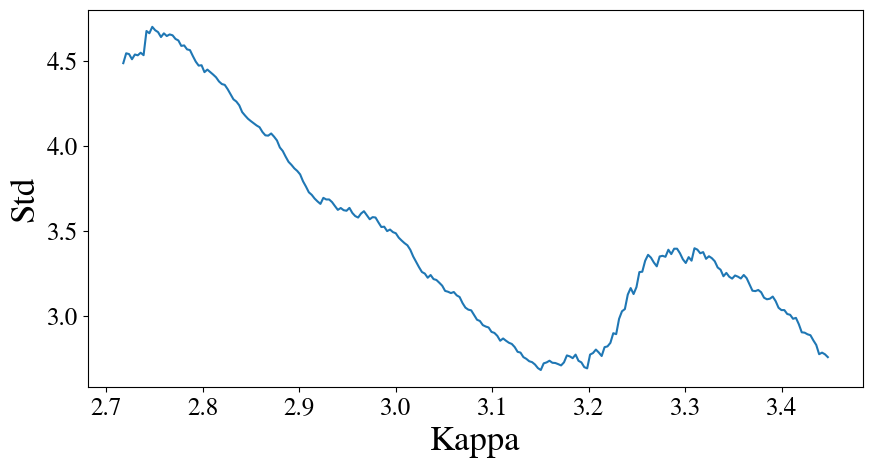

In [26]:
cpts_ctrls_allkp = np.array(cpts_ctrls_allkp)
cpts_ADs_allkp = np.array(cpts_ADs_allkp)
cpts_ctrl_std = cpts_ctrls_allkp.std(axis=1)
cpts_ctrl_mean = cpts_ctrls_allkp.mean(axis=1)

kps_keepidx_ctrl = np.bitwise_and(cpts_ctrls_allkp.mean(axis=1)>=3, cpts_ctrls_allkp.mean(axis=1)<=18)
#kps_keepidx_AD = np.bitwise_and(cpts_ADs_allkp.mean(axis=1)>=2, cpts_ADs_allkp.mean(axis=1)<=18)
#kps_keepidx_2grp = np.bitwise_and(kps_keepidx_AD, kps_keepidx_ctrl)


plt.plot(paras.kps[kps_keepidx_ctrl], cpts_ctrl_std[kps_keepidx_ctrl])
plt.xlabel("Kappa")
plt.ylabel("Std")


sel_kp = paras.kps[kps_keepidx_ctrl][np.argmin(cpts_ctrl_std[kps_keepidx_ctrl])]
post_paras.sel_kp = sel_kp
sel_kp

### change pts under selected kappa

In [27]:
cur_kp = sel_kp
_, cur_r, n = ndXmats_ctrl.shape
ncpts_ctrls_selected = np.array([update_kp(cur_kp, ix.U0, n, cur_r, paras) 
                                 for ix in cpts_ctrls])
cpts_ctrls_selected = [cur_cpts.chgMat[cur_ncpt-1, :cur_ncpt] 
                       for cur_ncpt, cur_cpts 
                       in zip(ncpts_ctrls_selected, cpts_ctrls)]


_, cur_r, n = ndXmats_AD.shape
ncpts_ADs_selected = np.array([update_kp(cur_kp, ix.U0, n, cur_r, paras) 
                               for ix 
                               in cpts_ADs])
cpts_ADs_selected = [cur_cpts.chgMat[cur_ncpt-1, :cur_ncpt] 
                     for cur_ncpt, cur_cpts 
                     in zip(ncpts_ADs_selected, cpts_ADs)]

In [28]:
dwells_ADs_selected = [np.diff(np.concatenate([[1], cpts_selected, [7200]]))/120
                       for cpts_selected 
                       in cpts_ADs_selected]
dwells_ctrls_selected = [np.diff(np.concatenate([[1], cpts_selected, [7200]]))/120
                         for cpts_selected 
                         in cpts_ctrls_selected]

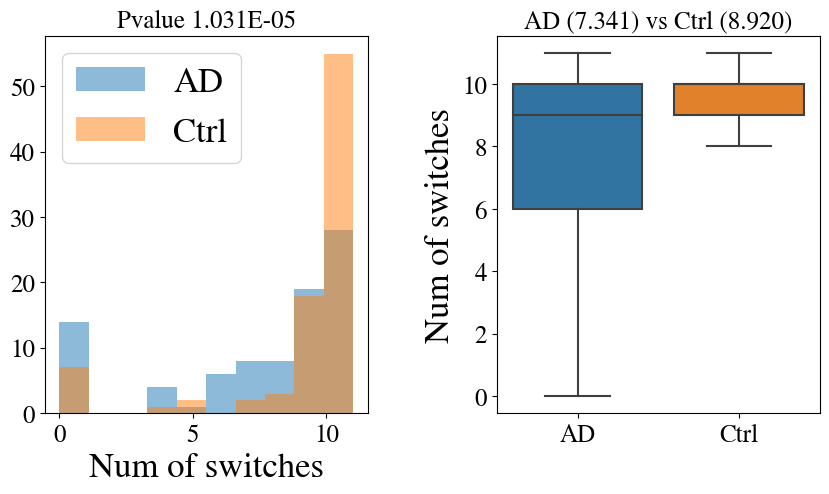

In [82]:
ncpts_ADs_selected = np.array([len(ix) for ix in cur_res.cpts_ADs_selected])
ncpts_ctrls_selected = np.array([len(ix) for ix in cur_res.cpts_ctrls_selected])
#pval = ttest_ind(ncpts_ADs_selected, ncpts_ctrls_selected, equal_var=False).pvalue
pval = mannwhitneyu(ncpts_ADs_selected, ncpts_ctrls_selected).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.hist(ncpts_ADs_selected, alpha=0.5, label="AD")
plt.hist(ncpts_ctrls_selected, alpha=0.5, label="Ctrl")
plt.xlabel("Num of switches")
plt.title(f"Pvalue {pval:.3E}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[ncpts_ADs_selected, ncpts_ctrls_selected], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.ylabel("Num of switches")
plt.title(f"AD ({ncpts_ADs_selected.mean():.3f}) vs Ctrl ({ncpts_ctrls_selected.mean():.3f})")
plt.savefig(FIG_ROOT/"cpt_boxplot.jpg")

##  Rank results

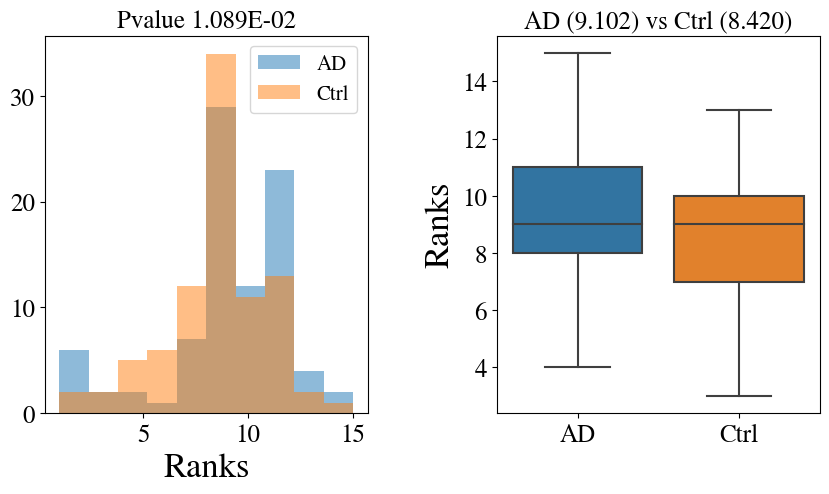

In [83]:
paras.cutoff=0.95
post_paras.rank_curoff = paras.cutoff 
AD_ws = CPDresult[2][88:]
ctrl_ws = CPDresult[2][:88]
rank_ADs = np.array([len(cumsum_cutoff(np.abs(AD_ws[ix]), paras.cutoff, ord_=2)) 
                     for ix 
                     in range(88)])
rank_ctrls = np.array([len(cumsum_cutoff(np.abs(ctrl_ws[ix]), paras.cutoff, ord_=2)) 
                       for ix 
                       in range(88)])

sel_rank_ADs = [cumsum_cutoff(np.abs(AD_ws[ix]), paras.cutoff, ord_=2)
                for ix 
                in range(88)]
sel_rank_ctrls = [cumsum_cutoff(np.abs(ctrl_ws[ix]), paras.cutoff, ord_=2) 
                  for ix 
                  in range(88)]

#pval = ttest_ind(rank_ADs, rank_ctrls, equal_var=False).pvalue
pval = mannwhitneyu(rank_ADs, rank_ctrls).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.hist(rank_ADs, alpha=0.5, label="AD")
plt.hist(rank_ctrls, alpha=0.5, label="Ctrl")
plt.xlabel("Ranks")
plt.title(f"Pvalue {pval:.3E}")
plt.legend(fontsize=15)

plt.subplot(122)
sns.boxplot(data=[rank_ADs, rank_ctrls], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.ylabel("Ranks")
plt.title(f"AD ({rank_ADs.mean():.3f}) vs Ctrl ({rank_ctrls.mean():.3f})")
plt.savefig(FIG_ROOT/f"rank_boxplot_{paras.cutoff*100:.0f}.jpg")

2 MannwhitneyuResult(statistic=3212.0, pvalue=0.011953515362349966)
14 MannwhitneyuResult(statistic=4444.0, pvalue=0.046588067372174094)


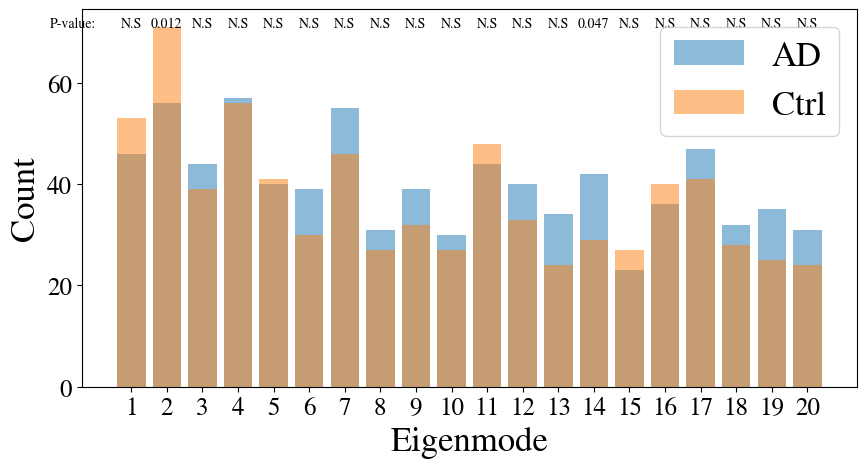

In [76]:
pvals = []
for ix in range(20):
    AD_num = np.count_nonzero(np.concatenate(sel_rank_ADs) == ix)
    ctrl_num = np.count_nonzero(np.concatenate(sel_rank_ctrls) == ix)
    AD_col = np.concatenate([np.ones(AD_num), np.zeros(88-AD_num)])
    ctrl_col = np.concatenate([np.ones(ctrl_num), np.zeros(88-ctrl_num)])
    test_res = mannwhitneyu(AD_col, ctrl_col)
    #test_res = ttest_ind(AD_col, ctrl_col)
    if test_res.pvalue < 0.05:
        print(ix+1, test_res)
    pvals.append(test_res.pvalue)
    
idxs, cts = np.unique(np.concatenate(sel_rank_ADs), return_counts=True)
cts_AD = np.array([cts[idxs==ix][0] for ix in range(0, 20)])
idxs, cts = np.unique(np.concatenate(sel_rank_ctrls), return_counts=True)
cts_ctrl = np.array([cts[idxs==ix][0] for ix in range(0, 20)])
plt.bar(np.arange(1, 21), cts_AD,  alpha=0.5, label="AD")
plt.bar(np.arange(1, 21), cts_ctrl, alpha=0.5, label="Ctrl")
plt.ylabel("Count")
plt.xlabel("Eigenmode")
plt.xticks(list(range(1, 21)), np.arange(1, 21))

text_h = 71
plt.text(0, text_h, f"P-value:", ha="right", fontsize=10)
for idx, pval in enumerate(pvals):
    if pval < 0.05:
        plt.text(idx+1, text_h, f"{pval:.3f}", ha="center", fontsize=10)
    else:
        #pass
        plt.text(idx+1, text_h, f"N.S", ha="center", fontsize=10)
plt.legend()

plt.savefig(FIG_ROOT/f"eigmode_count_barplot_{paras.cutoff*100:.0f}.jpg")

In [33]:
for ix in range(20):
    AD_part = np.log10(np.abs(AD_ws[:, ix]))
    ctrl_part = np.log10(np.abs(ctrl_ws[:, ix]))
    test_res = mannwhitneyu(AD_part, ctrl_part)
    if test_res.pvalue < 0.05/20:
        print(ix+1, np.mean(AD_part), np.mean(ctrl_part), test_res.pvalue)

4 0.01095417903055046 -0.28851559652959663 0.0020999985931894976
5 -0.1923087408608805 -0.5113790567367049 0.0016678857246507802
6 -0.2956276936182839 -0.66348536516945 7.861926555998352e-05
7 -0.05515500684083792 -0.47842775675291854 2.2796468891762555e-05
8 -0.4008589861263187 -0.7579888086134322 0.0008865493679810031
9 -0.2511777072863225 -0.5470588915600877 0.0008960024810271244
10 -0.2452047840704398 -0.7642461777973147 8.524350261091207e-06
11 -0.15818298154416635 -0.4846896928038031 0.0020383324500136465
12 -0.26869415582958245 -0.5420683023651164 0.0007314407315422371
14 -0.25216854772564995 -0.5976386241360441 0.00016256850497024087
19 -0.3380694829214507 -0.8013223563487977 5.075348091335223e-05
20 -0.32167753590187403 -0.677256844503141 5.33841242661985e-05


## Re-estimate the lambdas for each segment

In [34]:
singular_vals_ADs = []
singular_vals_ctrls = []

for ix in range(len(cpts_ADs_selected)):
    cur_singular_vals = est_singular_vals(cpts_ADs_selected[ix], ndXmats_AD[ix], nXmats_AD[ix])
    singular_vals_ADs.append(cur_singular_vals)
    
for ix in range(len(cpts_ctrls_selected)):
    cur_singular_vals = est_singular_vals(cpts_ctrls_selected[ix], ndXmats_ctrl[ix], nXmats_ctrl[ix])
    singular_vals_ctrls.append(cur_singular_vals)

In [35]:
dwells = dwells_ADs_selected
singular_vals = singular_vals_ADs

dwells_collect = ddict(list)
for ix in range(88):
    cur_dwell = dwells[ix]
    cur_singular_val = singular_vals[ix]
    U_idxs = np.argmax(np.abs(cur_singular_val), axis=0) + 1
    for iy in range(1, 21):
        dwells_collect[iy].append(cur_dwell[U_idxs==iy].sum())
        
dwells_ADs_collect = dwells_collect

In [36]:
dwells = dwells_ctrls_selected
singular_vals = singular_vals_ctrls

dwells_collect = ddict(list)
for ix in range(88):
    cur_dwell = dwells[ix]
    cur_singular_val = singular_vals[ix]
    U_idxs = np.argmax(np.abs(cur_singular_val), axis=0) + 1
    for iy in range(1, 21):
        dwells_collect[iy].append(cur_dwell[U_idxs==iy].sum())
        
dwells_ctrls_collect = dwells_collect

In [37]:
sig_idxs = []
sig_idx_pvals = []
for ix in range(1, 21):
    test_res = scipy.stats.mannwhitneyu(dwells_ADs_collect[ix], dwells_ctrls_collect[ix])
    if test_res.pvalue < 0.05:
        print(ix, test_res)
        sig_idxs.append(ix)
        sig_idx_pvals.append(f"{ix}\n ({test_res.pvalue:.3f})")

2 MannwhitneyuResult(statistic=2995.5, pvalue=0.004627591911594031)
4 MannwhitneyuResult(statistic=3019.0, pvalue=0.0016400144233023246)
7 MannwhitneyuResult(statistic=4503.0, pvalue=0.024807991793799496)


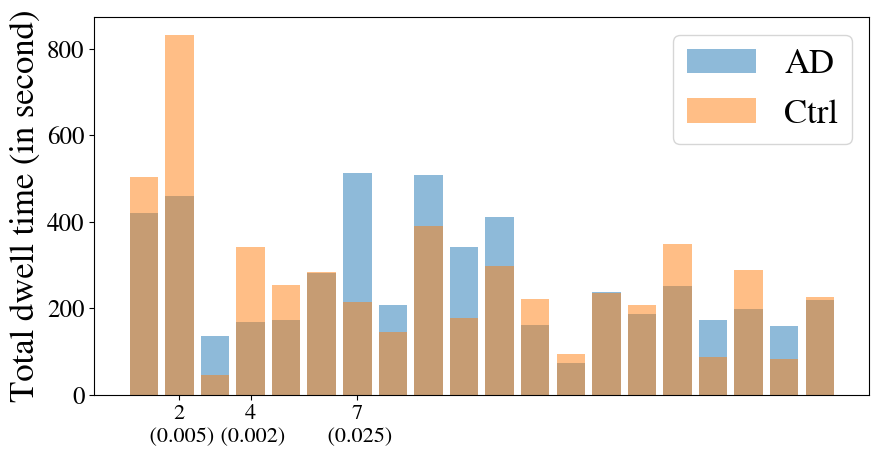

In [38]:
plt.bar(list(range(1, 21)), [np.sum(dwells_ADs_collect[ix]) for ix in range(1, 21)], alpha=0.5, label="AD")
plt.bar(list(range(1, 21)), [np.sum(dwells_ctrls_collect[ix]) for ix in range(1, 21)], alpha=0.5, label="Ctrl")
#plt.xlabel("combined U and V")
plt.ylabel("Total dwell time (in second)")
plt.xticks(sig_idxs, sig_idx_pvals, fontsize=16)
plt.legend()

## Save updated results

In [77]:
cur_res.post_paras = post_paras

cur_res.singular_vals_ADs = singular_vals_ADs
cur_res.cpts_ADs_selected = cpts_ADs_selected
cur_res.dwells_ADs_selected = dwells_ADs_selected
cur_res.rank_ADs = rank_ADs
cur_res.sel_rank_ADs = sel_rank_ADs


cur_res.singular_vals_ctrls = singular_vals_ctrls
cur_res.cpts_ctrls_selected = cpts_ctrls_selected
cur_res.dwells_ctrls_selected = dwells_ctrls_selected
cur_res.rank_ctrls = rank_ctrls
cur_res.sel_rank_ctrls = sel_rank_ctrls

In [78]:
save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res, False)

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs_selected.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls_selected.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/nXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../m